### Imports

In [72]:
import numpy as np 
import pandas as pd
from pulsee import simulation as sim, quantum_computing as qc, operators as op 
from pulsee.many_body import tensor_product

### Quantum System Setup
Spin-$\frac{1}{2}$ system with $\gamma/2\pi = 4.00$ MHz/T (see Candoli thesis §4.1) and $B_0 = 1$ T:

In [73]:
CORRELATED = True
QUANTUM_NUMBER = 0.5
GAMMA_2PI = 4.00 
B_0 = 1

### Pulse
Set up single mode pulse of form 
$$\mathbf{B}_1(t) = 2 B_1 \cos(2\pi \nu + \delta)\cdot \hat{\mathbf{n}}(\theta, \phi)$$
where $\theta$ and $\phi$ are the polar and azimuthal angles respectively. $B_1$ in T, $\nu$ in MHz, $\delta$, $\phi$, and $\theta$ in radians. TODO: $\nu$ depends on $e^2 q Q $ and $\eta$? What is $\eta$? Why?

For simplest case apply $\pi/2$ pulse with $B_1 = B_0 / 100 $, $ \nu = (\gamma/2\pi) \cdot B_0 $, $\delta = \phi =0$, $\theta=\pi/2$.

In [74]:
B_1 = B_0 / 100
FREQ = GAMMA_2PI * B_0
PHASE = 0
POLAR_B = np.pi / 2 
AZIMUTHAL_B = 0 
PULSE_TIME = 1 / (4 * FREQ)
mode = pd.DataFrame([(FREQ, 2 * B_1, PHASE, POLAR_B, AZIMUTHAL_B)],
					columns=['frequency', 'amplitude', 'phase', 'theta_p', 'phi_p'])

### Experiment Settings

In [75]:
ACQUISITION_TIME = 100 # in microseconds
T2 = 100

### Hamiltonians
Here we add the desired Hamiltonian interaction terms. Add these to the following dictionary `args` with key as it appears in `nuclear_system_setup` function. The value should be the parameters of the associated Hamiltonian as it appears in `nuclear_system_setup`.

In [76]:
h_dict = {
	'hf_param': {
		'A': 1, # for now these are dummy constants. Not sure what to put here yet
		'B': 1	
	}
}

### Simulation
If `CORRELATED = True`, create correlated state density matrix by applying Hadamard gate and CNOT gate. Else use canonical density matrix.

In [77]:
initial_dm = None
initial_dm_matrix = 'canonical'
if CORRELATED: 
	qs = qc.QubitSpace()
	control_qubit = qs.basis_ket_from_indices([0])
	target_qubit = qs.basis_ket_from_indices([0])

	control_qubit = qc.hadamard(control_qubit) 
	composite_state = control_qubit * target_qubit 
	corr_state = qc.cnot(composite_state)
	initial_dm = corr_state.density_matrix
	initial_dm_matrix = initial_dm.matrix

In [78]:
args = h_dict.copy()
spin_par = {'quantum number': QUANTUM_NUMBER, 'gamma/2pi': GAMMA_2PI} 
args['spin_par'] = [spin_par, spin_par]
args['initial_state'] = initial_dm_matrix

spin, h_unperturbed, initial_dm = sim.nuclear_system_setup(**args)

evolved_dm = sim.evolve(spin, h_unperturbed, dm_initial, 
						mode=mode, pulse_time=PULSE_TIME)

t, fid = sim.FID_signal(spin, h_unperturbed, evolved_dm, 
						acquisition_time=ACQUISITION_TIME, T2=T2)
						
f, ft = sim.fourier_transform_signal(t, fid, -1, 1)

Write simulation parameters and save plots to a directory. 

{'hf_param': {'A': 1, 'B': 1}}


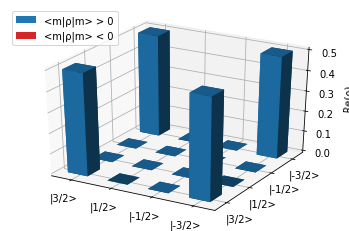

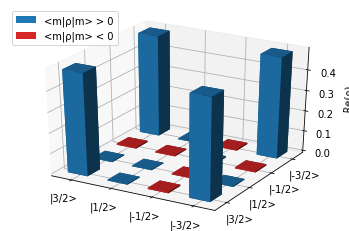

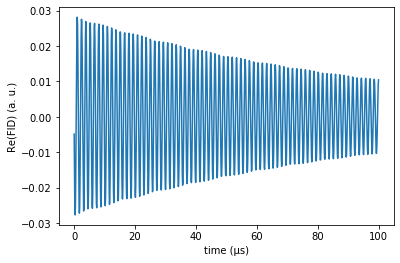

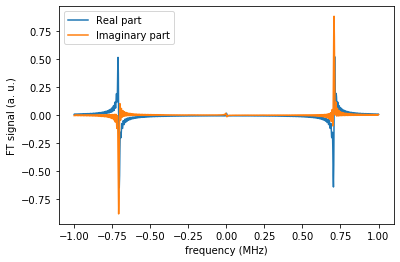

In [79]:
import os 
import json 

i = 1
while os.path.isdir(f'./simulation_results/sim_{i:04d}'):
	i += 1

sim_dir = f'./simulation_results/sim_{i:04d}/'
os.mkdir(sim_dir)

print(h_dict)
params = {
	'correlated_state': CORRELATED, 
	'quantum_number': QUANTUM_NUMBER, 
	'gamma_2pi': GAMMA_2PI, 
	'pulse_params': {
		'amplitude': 2 * B_1, 
		'frequency': FREQ, 
		'phase': PHASE, 
		'theta_p': POLAR_B, 
		'phi_p': AZIMUTHAL_B, 
		'pulse_time': PULSE_TIME
	},
	'acquisition_time': 10, 
	't2': T2,
	'hamiltonian_args': h_dict
}

params_file = open(os.path.join(sim_dir, 'params.json'), 'w')
json.dump(params, params_file, indent=4, separators=(',', ': '))
params_file.close()

sim.plot_real_part_density_matrix(initial_dm, 
								  save=True, 
								  destination=sim_dir,
								  name="InitialRealPartDensityMatrix")
sim.plot_real_part_density_matrix(evolved_dm,
								  save=True, 
								  destination=sim_dir,
								  name="EvolvedRealPartDensityMatrix")
sim.plot_real_part_FID_signal(t, fid, save=True, destination=sim_dir)
_ = sim.plot_fourier_transform(f, ft, save=True, destination=sim_dir)
